# PyTorch Custom Datasets

A **custom dataset** is a collection of data relating to a specific problem you're working on.

In essence, a **custom dataset** can be comprised of almost anything.

# Domain Libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions...

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.2.1+cu121'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
! nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## 1. Get Data

Our dataset is a subset of the food101 dataset.

Food101 Starts with 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images(~ 75 training, 25 testing).

**Tip**

When starting out ML projects, it's important to try things on a small scale and increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [5]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")



In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an Image

Let's write some code to:
1. Get all of the image paths using `pathlib.Path.glob()` to find all of the files ending in `.jpg`.
2. Pick a random image path using Python's `random.choice()`.
3. Get the Image class name using `pathlib.Path.parent.stem`.
4. And since we're working with images, we'll open the random image path using `PIL.Image.open()` (PIL stands for Python Image Library).
5. We'll then show the image and print metadata.

Random image path: data/pizza_steak_sushi/train/sushi/1957449.jpg
Image class: sushi
Image height: 512
Image width: 512


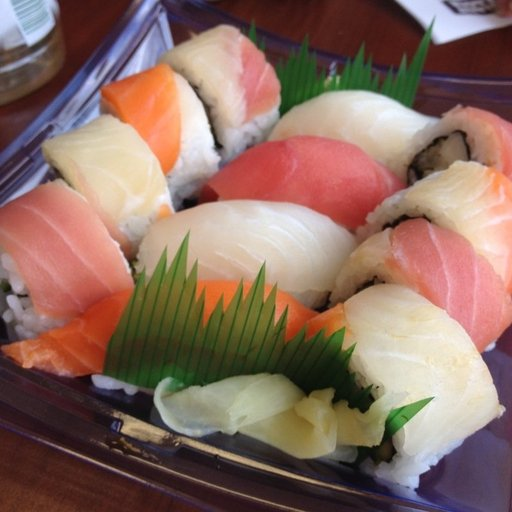

In [8]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img


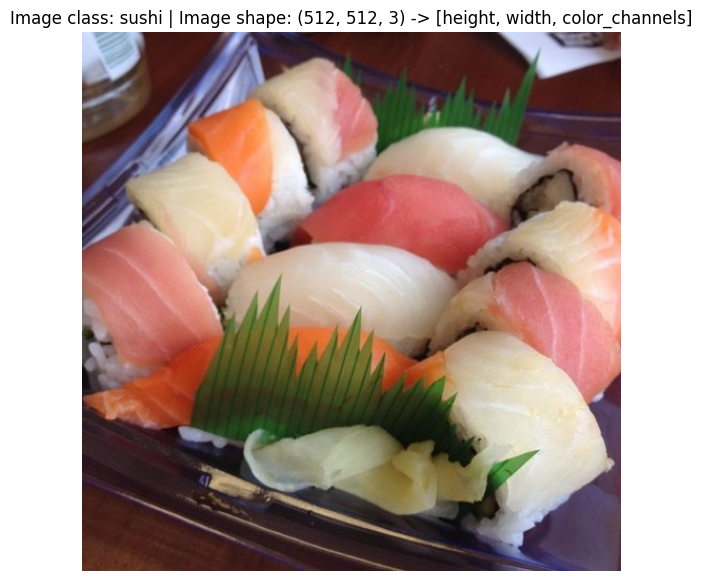

In [9]:
# Visualizing image using matplotlib library

import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## 3. Transforming Data

Before we can use our image data with PyTorch :

1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently into `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`

There are several different kinds of pre-built datasets and dataset loaders for PyTorch, depending on the problem you're working on.


Problem space	  -->      Pre-built Datasets and Functions
* Vision	     -->         torchvision.datasets

* Audio   --> 	torchaudio.datasets

* Text   --> 	torchtext.datasets

* Recommendation system   -->  	torchrec.datasets

Since we're working with a vision problem, we'll be looking at **`torchvision.datasets`** for our data loading functions as well as **`torchvision.transforms`** for preparing our data.

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

**torchvision.transforms** contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for **data augmentation** (the practice of altering data to make it harder for a model to learn, we'll see this later on) purposes.


To get experience with torchvision.transforms, let's write a series of transform steps that:

1. Resize the images using **transforms.Resize()** (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website).

2. Flip our images randomly on the horizontal using **transforms.RandomHorizontalFlip()**(this could be considered a form of data augmentation because it will artificially change our image data).

3. Turn our images from a PIL image to a PyTorch tensor using **transforms.ToTensor()**.

We can compile all of these steps using **torchvision.transforms.Compose()**.

In [11]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

In [12]:
img_as_array.shape

(512, 512, 3)

In [13]:
data_transform(img).shape # It takes PIL image as argument rather than image converted into numpy array..

torch.Size([3, 64, 64])

 an image of size [256, 256, 3] will have 16x more pixels than an image of size [64, 64, 3] ((256 * 256 * 3)/(64 * 64 * 3)=16).

 the tradeoff is that more pixels requires more computations.

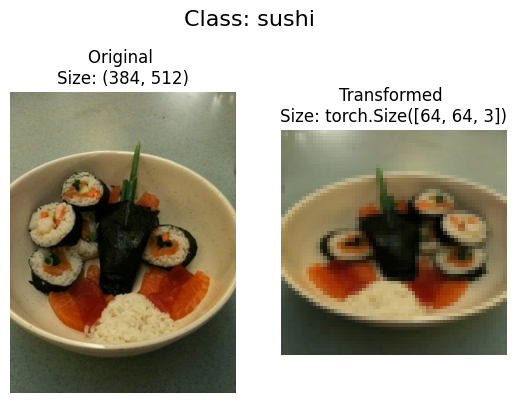

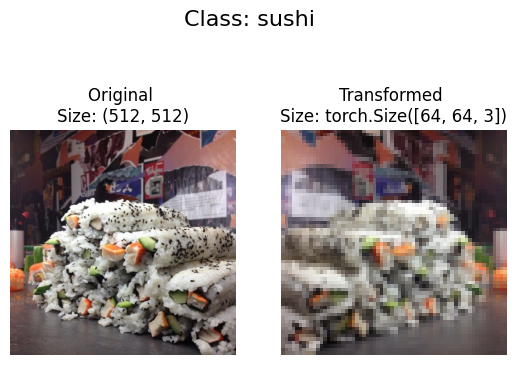

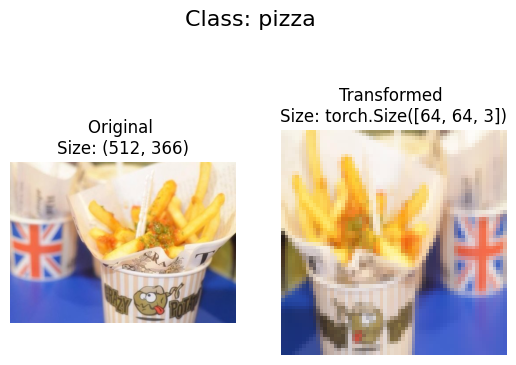

In [14]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1,  ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## 4. Option 1: Loading Image Data Using ImageFolder

We can load image classification data using `torchvision.datasets.ImageFolder`

In [15]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [16]:
# Get class names as a list
class_name = train_data.classes
class_name

['pizza', 'steak', 'sushi']

In [17]:
# Get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [19]:
# Index on the train_data Dataset to get a single image and label/target associated with that image
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


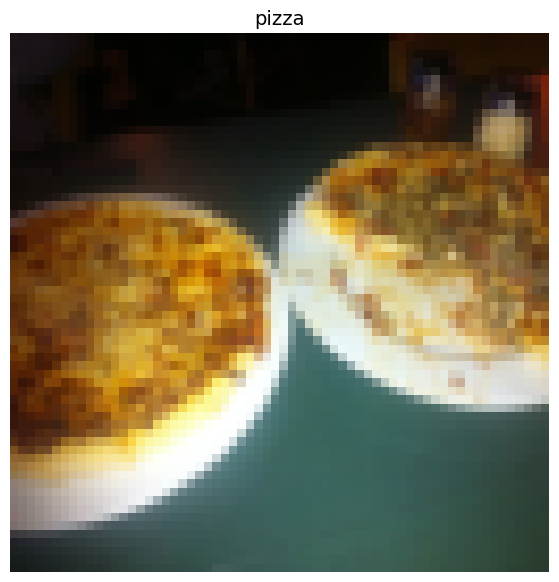

In [20]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_name[label], fontsize=14);

## 4.1 Turn loaded images into DataLoader's

A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time.


num_workers:

It defines how many subprocesses will be created to load your data.

Think of it like this, the higher value num_workers is set to, the more compute power PyTorch will use to load your data.

In [21]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True,
                              )

test_dataloader = DataLoader( dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=False,
                              )

train_dataloader , test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ab7b44db4f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ab7b4516980>)

In [22]:
len(train_data), len(test_data)

(225, 75)

In [23]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [24]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")


Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


## 5. Option 2: Loading Image Data with a Custom Dataset

Now we look after another way to load images...

To see this in action, let's work towards replicating **torchvision.datasets.ImageFolder()** by subclassing **torch.utils.data.Dataset** (the base class for all Dataset's in PyTorch).

We'll start by importing the modules we need:

* Python's **os** for dealing with **directories** (our data is stored in directories).

* Python's **pathlib** for dealing with **filepaths**(each of our images has a unique filepath).

* **torch** for all things PyTorch.

* **PIL's Image class** for loading images.

* **torch.utils.data.Dataset** to subclass and create our own **custom Dataset**.

* **torchvision.transforms** to turn our images into **tensors**.

* Various types from **Python's typing module** to add **type hints** to our code

In [25]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [26]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx    # Now we'll try to replicate this code by creating a helper function

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

Let's write a helper function capable of creating a list of class names and a dictionary of class names and their indexes given a directory path.

To do so, we'll:

* Get the class names using **os.scandir()** to traverse a target directory (ideally the directory is in standard image classification format).

* Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).

* Turn the class names into a dictionary of numerical labels, one for each class.

In [27]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [28]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}......please check file structure.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [29]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

Now we're ready to build our own custom Dataset.

We'll build one to replicate the functionality of **torchvision.datasets.ImageFolder()**.

Let's break it down:

* Subclass **torch.utils.data.Dataset**.

* Initialize our subclass with a **targ_dir** parameter (the target data directory) and **transform parameter** (so we have the option to transform our data if needed).

* Create several attributes for **paths** (the paths of our target images), **transform** (the transforms we might like to use, this can be None), **classes and class_to_idx** (from our find_classes() function).

* Create a function to `load images` from file and return them, this could be using PIL or torchvision.io (for input/output of vision data).

* Overwrite the __len__ method of **torch.utils.data.Dataset** to return the number of samples in the Dataset, this is recommended but not required. This is so you can call len(Dataset).

* Overwrite the __getitem__ method of **torch.utils.data.Dataset** to return a single sample from the Dataset, this is required.

In [30]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [31]:
# Create a transform
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [32]:
# Let's turn our training images (contained in train_dir) and our testing images (contained in test_dir) into Dataset's
#  using our own ImageFolderCustom class.

train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7ab7b43afa60>,
 <__main__.ImageFolderCustom at 0x7ab7b43af1c0>)

In [33]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [34]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [35]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [36]:
# Check for equality amongst our ImageFoldercustom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


### 5.3 Create a function to display random images

Let's create a helper function called display_random_images() that helps us visualize images in our Dataset's.

Specifically, it'll:

* Take in a **Dataset** and a number of other parameters such as classes (the names of our target classes), the number of images to display (n) and a random seed.

* To prevent the display getting out of hand, we'll cap n at 10 images.

* Set the random seed for reproducible plots (if seed is set).

* Get a list of random sample indexes (we can use **Python's random.sample()** for this) to plot.

* Setup a **matplotlib** plot.

* Loop through the random sample indexes found in step 4 and plot them with matplotlib.

* Make sure the sample images are of shape HWC (height, width, color channels) so we can plot them.

In [38]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)  # We will get 10 random indexes from 0 to 225

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

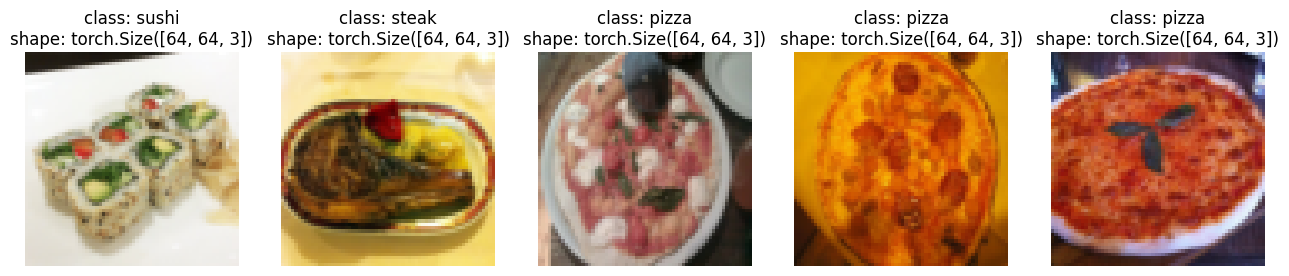

In [41]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_name,
                      seed=None)

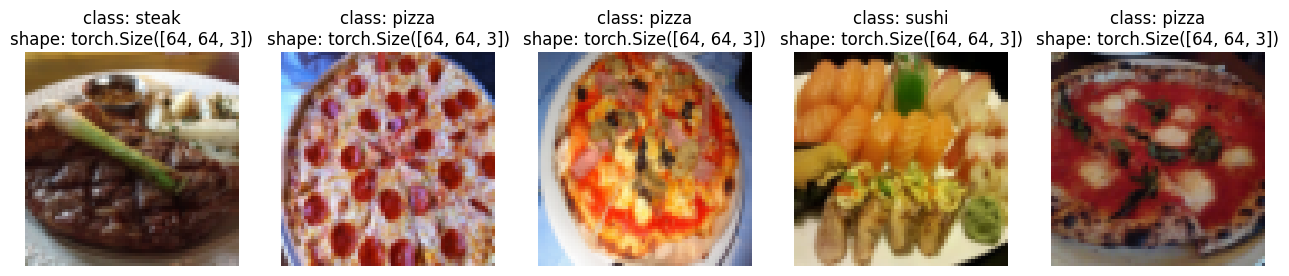

In [45]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_name,
                      seed=None) # Try setting the seed for reproducible images

### 5.4 Turn custom loaded images into DataLoader's

In PyTorch, the **num_workers** parameter in the **DataLoader** class specifies **how many subprocesses to use for data loading**. It determines the number of parallel data loading processes to speed up data loading, especially when dealing with large datasets and complex data transformations.

When you set **num_workers to a value greater than 0**, PyTorch will use **multiple subprocesses to load the data in parallel**, which can significantly **speed up** the data loading process, especially if your data loading and preprocessing are bottlenecked by CPU processing rather than GPU computation.

* **num_workers=0** means ONLY the main process will load batches (that can be a bottleneck).

* **num_workers=1** means ONLY one worker (just not the main process) will load data but it will still be slow.

* The **num_workers** depends on the batch size and your machine.

In [48]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=BATCH_SIZE,
                                    num_workers=0,
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7ab7b3db9c60>,
 <torch.utils.data.dataloader.DataLoader at 0x7ab7b3db9c00>)

In [49]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 6. Other forms of transforms (data augmentation)

**Data augmentation** is a technique used in machine learning and deep learning to artificially **increase the diversity of your training dataset** by applying **various transformations to your existing data**. These transformations can include things like:

* **Rotation**: Rotating images by a certain angle.
* **Flip**: Flipping images horizontally or vertically.
* **Translation**: Shifting images horizontally or vertically.
* **Scaling**: Zooming in or out of images.
* **Shearing**: Tilting images along a certain axis.
* **Brightness adjustment**: Making images brighter or darker.
* **Contrast adjustment**: Increasing or decreasing the contrast of images.
* **Noise addition**: Adding random noise to images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one of a particular type of data augmentation used to train PyTorch **vision models** to **State of the Art levels (SOTA)**.....

Blog Post: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

We'll look technique called **`Trivial Augment`**


**Trivial augmentation** refers to simple and **basic data augmentation** techniques that don't involve complex transformations but still contribute to increasing the diversity of the dataset. These techniques are often straightforward and easy to implement. They might include:

* **Horizontal Flip**: Flipping images horizontally.

* **Vertical Flip**: Flipping images vertically.

* **Rotation**: Rotating images by a fixed angle (e.g., 90 degrees).

* **Brightness Adjustment**: Increasing or decreasing the brightness of images.





In [50]:
# Let's look at trivial augment
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

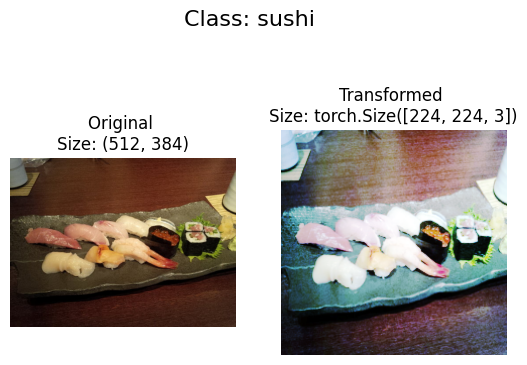

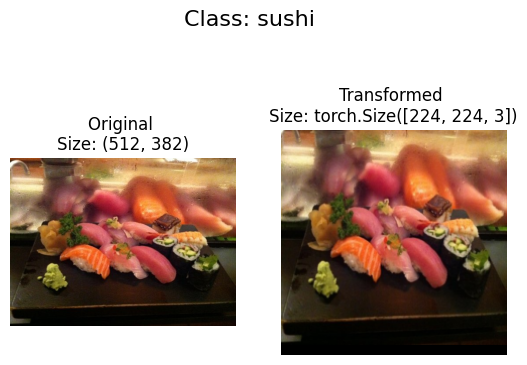

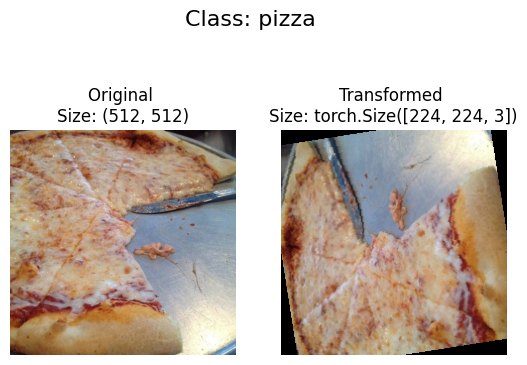

In [52]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for model 0

In [ ]:
# Create a simple transform
simple_transform =